# Load Lib

In [10]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset

In [11]:
processed_data_path = '../data/processed/combined_data.csv'

In [12]:
try:
    combined_df = pd.read_csv(processed_data_path, index_col = "Date", parse_dates = True)
    print("Successfully loaded combined DataFrame for fitting.")
except FileNotFoundError:
    print(f"Error: File {processed_data_path} not found. Run preprocessing notebook.")

# Separation of features (X) and target variable (y)
X = combined_df.drop("target", axis = 1)
y = combined_df["target"]

# Chronological division of data
train_size = int(0.8 * len(combined_df))

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"\nData chronological split complete.")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(combined_df):.2%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(combined_df):.2%})")
print(f"Training start date: {X_train.index.min()} | Training end date: {X_train.index.max()}")
print(f"Test start date: {X_test.index.min()} | Test end date: {X_test.index.max()}")

Successfully loaded combined DataFrame for fitting.

Data chronological split complete.
Training set size: 2200 (80.00%)
Test set size: 550 (20.00%)
Training start date: 2020-02-07 00:00:00 | Training end date: 2025-08-18 00:00:00
Test start date: 2023-06-06 00:00:00 | Test end date: 2025-08-18 00:00:00


# Hyperparameter Tuning

In [13]:
# Hyperparameters to be optimized in RandomForestClassifier
param_grid = {
    "n_estimators": [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    "max_features": ["sqrt", "log2"],
    "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Evaluate the optimized model


Starting Randomized Search for hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
\Best hyperparameters found:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}

--- Optimized Model Results ---
Accuracy: 0.5164
Precision: 0.4778
Recall: 0.5534
F1-Score: 0.5128

 Optimized Confusion Matrix:
[[144 153]
 [113 140]]


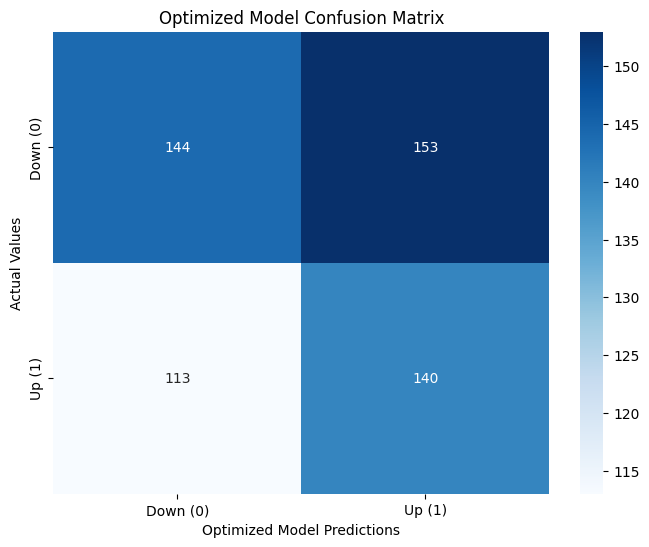

In [14]:
# Instantiate the base model for Randomized Search
rf = RandomForestClassifier(random_state = 42)

# Configure RandomizedSearchCV
# n_iter: Number of hyperparameter combinations to test (100 is a good starting number)
# cv: Number of folds for cross-validation (usually 5)
# n_jobs: -1 to use all processor cores to speed up the process
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 42, n_jobs = -1, scoring = "f1")

print("\nStarting Randomized Search for hyperparameter tuning...")

rf_random.fit(X_train, y_train)

print("\Best hyperparameters found:")
print(rf_random.best_params_)

# Get the best Randomized Search model
best_model = rf_random.best_estimator_

# Make predictions with the optimized model on the test set
y_pred_tuned = best_model.predict(X_test)

# Calculate and display performance metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print("\n--- Optimized Model Results ---")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")

# Generate and visualize the Confusion Matrix for the optimized model
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)

print("\n Optimized Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Down (0)', 'Up (1)'],
    yticklabels=['Down (0)', 'Up (1)'])
plt.xlabel('Optimized Model Predictions')
plt.ylabel('Actual Values')
plt.title('Optimized Model Confusion Matrix')
plt.show()

In [15]:
# --- Bloco para salvar o modelo otimizado ---
# Correção: O caminho do arquivo foi ajustado para a nova estrutura de pastas
model_output_path = '../data/model/'
model_filename_tuned = 'alpha_predictor_model_tuned.pkl'
os.makedirs(model_output_path, exist_ok=True)
joblib.dump(best_model, os.path.join(model_output_path, model_filename_tuned))

print(f"\nModelo otimizado salvo com sucesso em: {os.path.join(model_output_path, model_filename_tuned)}")


Modelo otimizado salvo com sucesso em: ../data/model/alpha_predictor_model_tuned.pkl
